# Advanced Image Models

## Objectif

Ce notebook permet de générer les jeux de données contenant les pixels des images, puis d'entrainer des modèles.

## 1. Paramètres des jeux de données

Veuillez renseigner les paramètres ci-dessous pour définir les jeux de données

In [16]:
# Define the dataset size
TRAIN_SIZE = 0.8
TEST_SIZE = 0.2

# Define the images characteristics
WIDTH = 100
HEIGHT = 100
KEEP_RATIO = True
GRAYSCALE = True

# Number of threads to use with images conversion
NB_THREADS = 4

# Automatic, do not touch
DIMENSIONS = 1 if GRAYSCALE else 3

## 2. Génération des jeux de données

Veuillez executer la cellule ci-dessous. Attention, l'étape de pré-processing des images peut être longue si vous avez un gros jeu de données. 

In [7]:
import os
import pickle
import src.data.data as data
import importlib
from src.data import transformer
from sklearn.model_selection import train_test_split

importlib.reload(transformer)
importlib.reload(data)

df = data.load_data()
target = df["prdtypecode"]
features = df.drop("prdtypecode", axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    train_size=TRAIN_SIZE, 
                                                    test_size=TEST_SIZE)

transformer = transformer.ImagePipeline(width=WIDTH, height=HEIGHT, 
                                     keep_ratio=KEEP_RATIO, 
                                     grayscale=GRAYSCALE,
                                     nb_threads=NB_THREADS)

img_output_dir = transformer.output_dir.split('/')[1]
pipeline = transformer.pipeline

print("Transformation du jeu de données d'entrainement")
X_train = pipeline.fit_transform(X_train)
print("Transformation du jeu de données de test")
X_test = pipeline.transform(X_test)

files = {
    "data/training/X_train.pkl": X_train,
    "data/training/X_test.pkl": X_test,
    "data/training/y_train.pkl": y_train,
    "data/training/y_test.pkl": y_test
}

print("Enregistrement des données")
if not os.path.exists("data/training"):
    os.makedirs("data/training")

for filename in files.keys():
    with open(filename,'wb') as fp:
            pickle.dump(files[filename], fp)

Avancement : 100%
Enregistrement des données


Attention, il est maintenant recommandé de redémarrer le kernel Jupyter pour vider la RAM utilisée par la cellule ci-dessus.

## 3. Entrainement du modèle

Instanciez votre modèle dans la cellule ci-dessous, puis executer les cellules à la suite.

In [29]:
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import os
import pickle

X_train = pickle.load(open("data/training/X_train.pkl", "rb"))
y_train = pickle.load(open("data/training/y_train.pkl", "rb"))

X_test = pickle.load(open("data/training/X_test.pkl", "rb"))
y_test = pickle.load(open("data/training/y_test.pkl", "rb"))


X_train = X_train.reshape([-1, WIDTH, HEIGHT, DIMENSIONS])
X_test = X_test.reshape([-1, WIDTH, HEIGHT, DIMENSIONS])

# Transformation des labels en vecteurs catégoriels binaires
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [23]:
%matplotlib inline
import numpy as np

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D


from sklearn import metrics

import matplotlib.pyplot as plt
from matplotlib import cm

import itertools

# Instanciation d'une couche d'input avec comme argument la taille des images
inputs = Input(shape=(WIDTH, HEIGHT, DIMENSIONS), name="Input")

# Instanciation d'une couche de convolution
first_layer = Conv2D(
  filters = 32,        # La couche sera composée de 32 matrices de convolution.   
  kernel_size = (5, 5),# le noyau de convolution sera de dimension 5x5 (25 coefficients par filtre).
  padding = 'valid',   # pour que le noyau ne puisse pas dépasser les bords de l'image.   
  activation = 'relu',
  name="First_layer"
)

# Instanciation d'une couche de max-pooling
second_layer = MaxPooling2D(pool_size=(2,2), name="Second_layer")

# Ajoute une couche de dropout pour couper une partie des connexions
third_layer = Dropout(
    rate = 0.2 # Indique que l'on coupe 20% des connexions entre la couche précédente et la couche suivante
)

# Ajoute une couche permettant d'aplatir une matrice en un vecteur
fourth_layer = Flatten()

# Ajout d'une couche dense
fifth_layer = Dense(units = 128,
                    activation = 'relu')

# Ajout d'une dernière couche dense pour renvoyer les prédictions de probabilité pour chaque classe
output_layer = Dense(units = 2906,
                     activation='softmax')
                     
# Ajout des couches au modèle
x=first_layer(inputs)
x=second_layer(x)
x = third_layer(x)
x = fourth_layer(x)
x = fifth_layer(x)
outputs = output_layer(x)

# Instancie du modèle
model = Model(inputs = inputs, outputs = outputs)

# Compile le modèle
model.compile(loss='categorical_crossentropy', # fonction de perte
              optimizer='adam',                # algorithme d'optimisation
              metrics=['accuracy'])            # métrique d'évaluation

# Entraine le modèle
training_history = model.fit(X_train, y_train,
                             validation_split = 0.2,
                             epochs = 10,
                             batch_size = 200)

# Stocke les précisions d'entraînement et de test obtenues
train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']

## Evolution des précisions tout au long de l'entrainement

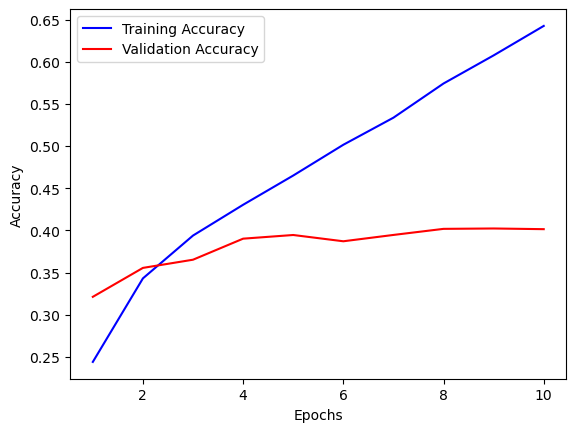

In [25]:
# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , 11, 1),
         training_history.history['accuracy'],
         label = 'Training Accuracy',
         color = 'blue')

# Courbe de la précision sur l'échantillon de test
plt.plot(np.arange(1 , 11, 1),
         training_history.history['val_accuracy'], 
         label = 'Validation Accuracy',
         color = 'red')

# Affichage de la légende
plt.legend()

# Affichage de la figure
plt.show()

## Prédiction des classes de l'échantillon de test et affichage du compte rendu de performance

In [30]:
test_pred = model.predict(X_test)

test_pred_class = test_pred.argmax(axis = 1)
y_test_class = y_test.argmax(axis = 1)

print(metrics.classification_report(y_test_class, test_pred_class))

531/531 [==============================] - 9s 16ms/step
              precision    recall  f1-score   support

          10       0.46      0.37      0.41       613
          40       0.48      0.34      0.40       497
          50       0.26      0.16      0.20       355
          60       0.36      0.20      0.25       157
        1140       0.45      0.17      0.25       528
        1160       0.83      0.80      0.81       810
        1180       0.13      0.09      0.11       138
        1280       0.20      0.14      0.17       986
        1281       0.10      0.04      0.06       400
        1300       0.35      0.48      0.40      1015
        1301       0.33      0.12      0.17       171
        1302       0.11      0.13      0.12       508
        1320       0.44      0.11      0.18       678
        1560       0.37      0.27      0.31      1016
        1920       0.72      0.58      0.65       855
        1940       0.30      0.13      0.18       169
        2060       0.22  

## Affichage de la matrice de confusion

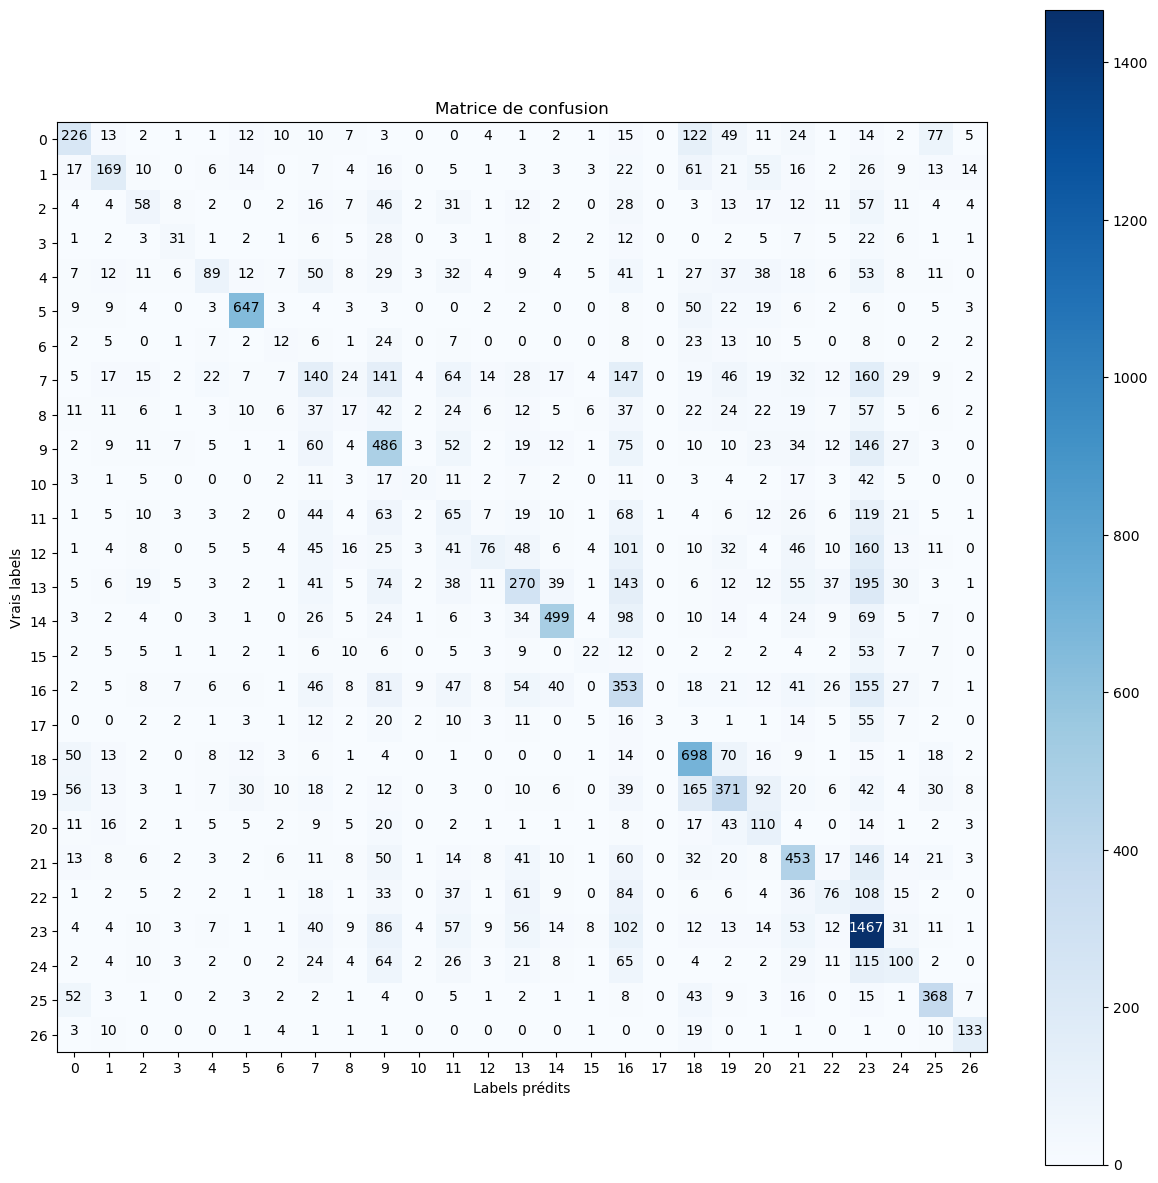

In [33]:
cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class)

classes = range(0,27)

plt.figure(figsize=(15,15))

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()